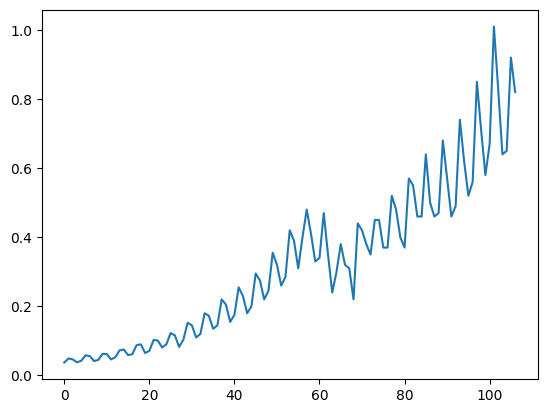

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

datos = pd.read_csv('coca_cola_earnings.csv', sep=";",decimal=",")
y = datos.iloc[:,1]

plt.plot(y)
plt.show()

In [20]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs

# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y,maxlag=10) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 4
d = ndiffs(y, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: 1.0592123446677049
p-value: 0.9948530334564032
Regular differences:  1
Seasonal differences: 1


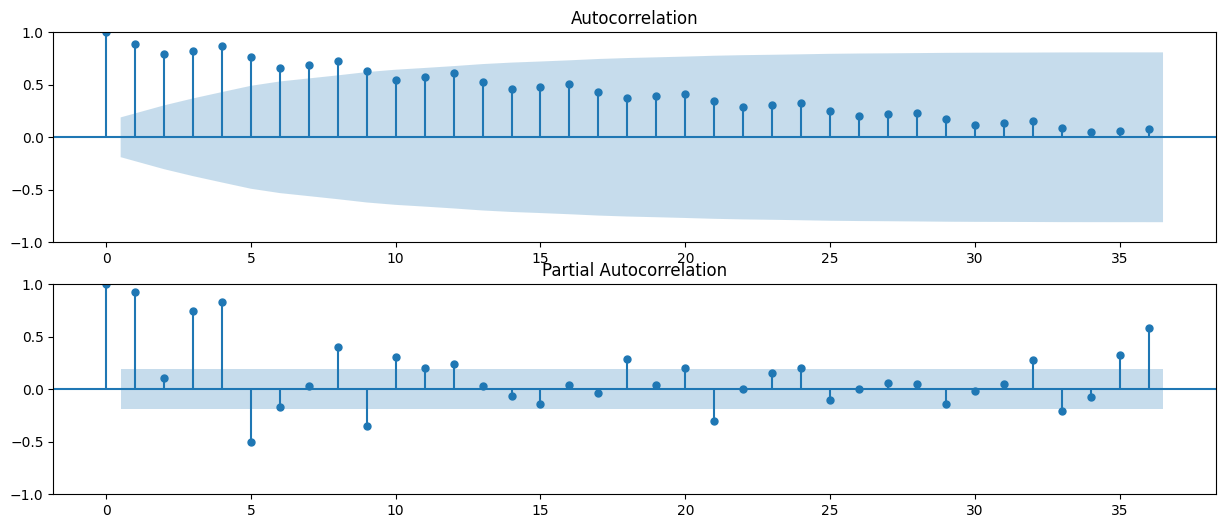

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 36 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y, lags = nlags, ax=ax[0])
plot_pacf(y, lags = nlags, method="ols", ax=ax[1])
plt.show()


# APARTADO 1

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  107
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                 193.833
Date:                           Fri, 12 Dec 2025   AIC                           -381.665
Time:                                   18:41:50   BIC                           -373.790
Sample:                                        0   HQIC                          -378.476
                                           - 107                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1718      0.061     -2.827      0.005      -0.291      -0.053
ar.S.L4       -0.4390      0.089     -4.960

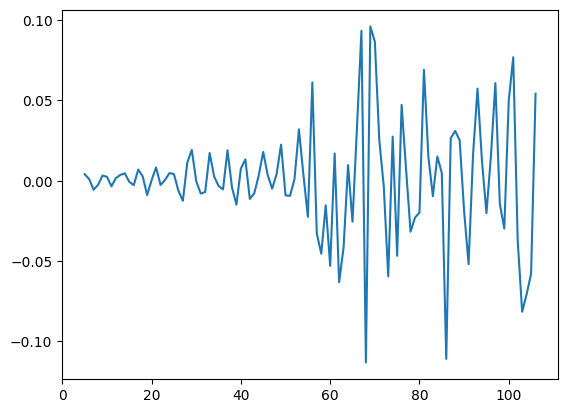

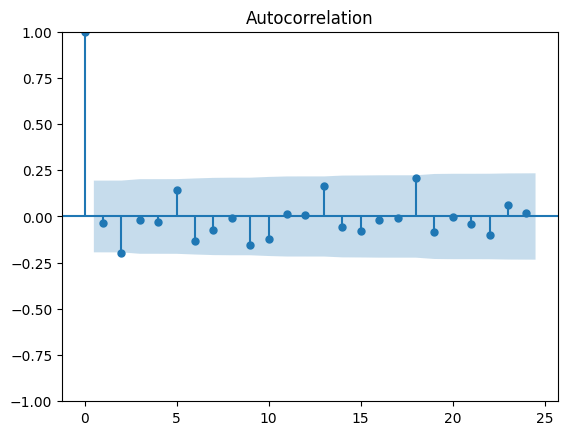

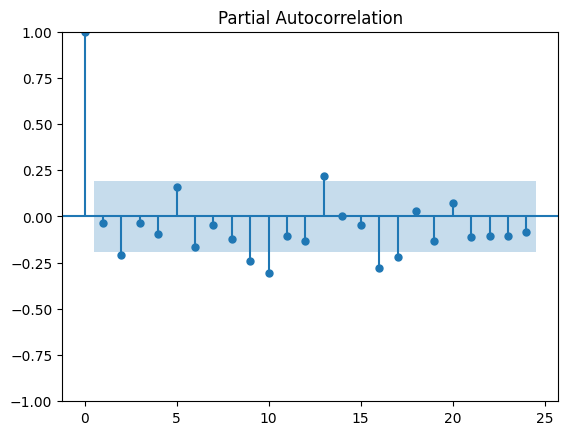

In [49]:
s = 4

# HEMOS ENCONTRADO UN MODELO (0,1,1) (0,1,1,4) Y OTRO MODELO (1,1,0) (1,1,0,4)
fit = SARIMAX(endog = y, order = (1,1,0), seasonal_order = (1,1,0,s)).fit()
print(fit.summary())
residuos = fit.resid[s+1:]

nlags=24

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()

Ljung-Box for the residuals
      lb_stat  lb_pvalue
25  27.027474   0.354513
Shapiro test for residuals: Statistic value 0.9442316764530053 p-value 0.0003041211991168024


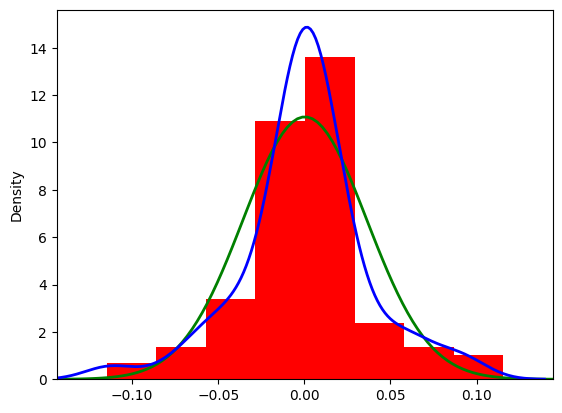

In [48]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[25])

print("Ljung-Box for the residuals")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapiro test for residuals: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)

plt.show()

Ljung-Box for squared residuals
      lb_stat  lb_pvalue
20  59.249821   0.000009


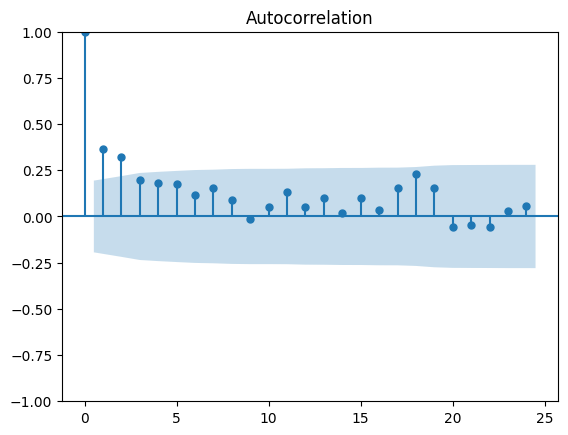

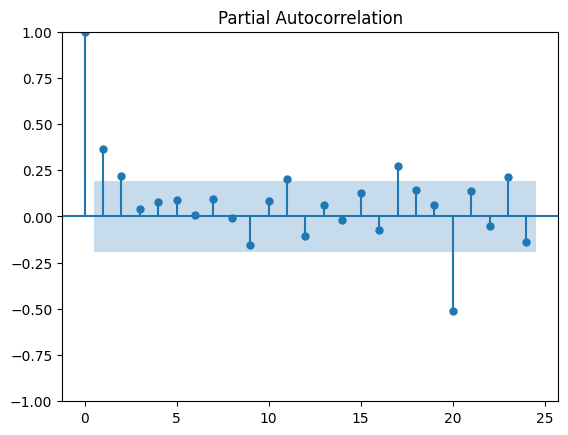

In [44]:
# Study the squared residuals for SWN

box_test2 = sm.stats.acorr_ljungbox(residuos**2, lags=[20])
print("Ljung-Box for squared residuals")
print(box_test2)

plot_acf(residuos**2,lags=nlags)
plt.show()
plot_pacf(residuos**2,lags=nlags,method="ols")
plt.show()

# APARTADO 2.

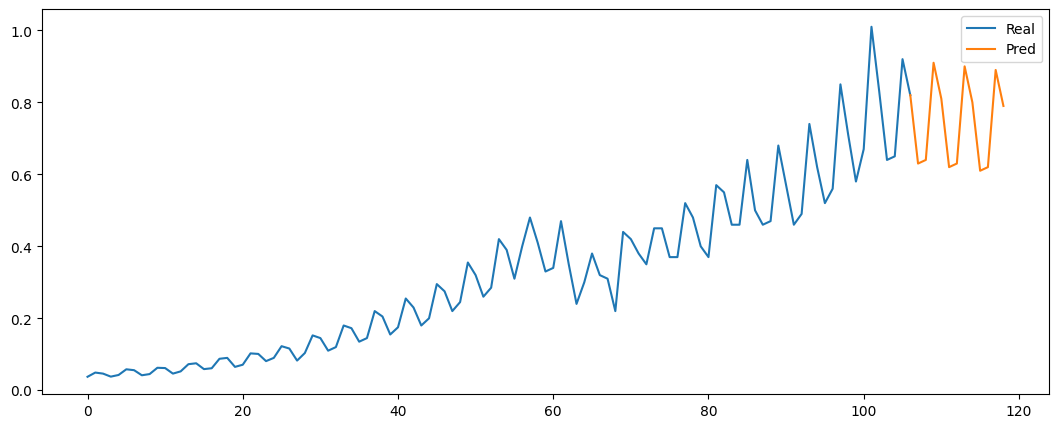

In [25]:
# Pintamos las siguientes 24 predicciones
y_pred = fit.forecast(steps = 12)

# Ponemos el último índice real
y_pred.loc[len(y)-1] = y[len(y)-1]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (13,5))
plt.plot(y, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()

In [26]:
# MORE FORECAST INFORMATION

forecast_result = fit.get_forecast(steps=12)
y_pred = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)  
stderr = forecast_result.se_mean 

print("point predictions")
print(y_pred)
print("standard error of point predictions")
print(stderr)
print("confidence intervals around point predictions")
print(conf_int)


point predictions
107    0.63
108    0.64
109    0.91
110    0.81
111    0.62
112    0.63
113    0.90
114    0.80
115    0.61
116    0.62
117    0.89
118    0.79
Name: predicted_mean, dtype: float64
standard error of point predictions
107    0.041419
108    0.058575
109    0.071739
110    0.082838
111    0.117150
112    0.143479
113    0.165675
114    0.185231
115    0.223047
116    0.255323
117    0.283953
118    0.309950
Name: var_pred_mean, dtype: float64
confidence intervals around point predictions
     lower value  upper value
107     0.548821     0.711179
108     0.525195     0.754805
109     0.769393     1.050607
110     0.647641     0.972359
111     0.390390     0.849610
112     0.348786     0.911214
113     0.575282     1.224718
114     0.436955     1.163045
115     0.172836     1.047164
116     0.119577     1.120423
117     0.333462     1.446538
118     0.182509     1.397491


In [27]:
# MORE FORECAST INFORMATION

media = np.mean(residuos)
desviacion_std = np.std(residuos)

# Standardized residuals
residuos_estand = (residuos - media) / desviacion_std

# Verification
#print("Standardized residuals:", residuos_estand)
print("Mean:", np.mean(residuos_estand))
print("Standard deviation:", np.std(residuos_estand))


quantile_2_5=np.quantile(residuos_estand, 0.025)
quantile_97_5=np.quantile(residuos_estand, 0.975)

print("We must compare the following numbers with +/- 1.96 from the standard normal")
print(quantile_2_5,quantile_97_5)

Mean: -2.3945986805640632e-17
Standard deviation: 1.0000000000000002
We must compare the following numbers with +/- 1.96 from the standard normal
-2.386430219466119 1.7447353488533968


In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

h = 24                      # horizonte de predicción
y_train = y[:-h]           # datos de entrenamiento
y_test  = y[-h:]           # datos reales fuera de muestra

s = 4                      # estacionalidad trimestral

fit1 = SARIMAX(
    endog = y_train,
    order = (1,1,0),
    seasonal_order = (4,1,0,s)
).fit()

y_pred1 = fit1.forecast(steps = h)

# Métricas
mae1  = mean_absolute_error(y_test, y_pred1)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred1))
mape1 = np.mean(np.abs((y_test - y_pred1) / y_test)) * 100

fit2 = SARIMAX(
    endog = y_train,
    order = (0,1,1),
    seasonal_order = (0,1,1,s)
).fit()

y_pred2 = fit2.forecast(steps = h)

# Métricas
mae2  = mean_absolute_error(y_test, y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
mape2 = np.mean(np.abs((y_test - y_pred2) / y_test)) * 100


# ============================
# 4️⃣ RESULTADOS FINALES
# ============================

print("Modelo 1 SARIMA(1,1,0)(4,1,0)s=4")
print("MAE :", mae1)
print("RMSE:", rmse1)
print("MAPE:", mape1, "%")

print("\nModelo 2 SARIMA(0,1,1)(0,1,1)s=4")
print("MAE :", mae2)
print("RMSE:", rmse2)
print("MAPE:", mape2, "%")

Modelo 1 SARIMA(1,1,0)(4,1,0)s=4
MAE : 0.06701631360664373
RMSE: 0.08271254585695245
MAPE: 11.411350253897849 %

Modelo 2 SARIMA(0,1,1)(0,1,1)s=4
MAE : 0.05368562751885043
RMSE: 0.07037552432938649
MAPE: 8.259218937990818 %
